[![preview notebook](https://img.shields.io/static/v1?label=render%20on&logo=github&color=87ce3e&message=GitHub)](https://github.com/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on mybinder.org](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/open-atmos/PySDM.git/main?urlpath=lab/tree/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)
[![launch on Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-atmos/PySDM/blob/main/examples/PySDM_examples/Gedzelman_and_Arnold_1994/fig_2.ipynb)

#### based on Fig. 2 from Gedzelman and Arnold 1994 (JGR)  "_Modeling the isotopic composition of precipitation_"
https://doi.org/10.1029/93JD03518

**notes**:
- "b" defined in eq. (18) lacks multiplication by $\rho_\text{s}$ - units do not match, plot matches the one generated with $\rho_\text{s}$ included - seems a typo in eq. (18)

**extentions (see notebook cells below first figure):**
- multiple isotopes (D, $^{18}$O, $^{17}$O)
- modern parameterisations: Horita & Wesolowski '94 for D & $^{18}$O equil. fractionation, Barkan & Luz '05 for $^{17}$O, Hellmann & Harvey '20 for diffusivities
- environment ratio plot axis
- temperature dependence

In [1]:
import os, sys
os.environ['NUMBA_THREADING_LAYER'] = 'workqueue'  # PySDM & PyMPDATA don't work with TBB; OpenMP has extra dependencies on macOS
if 'google.colab' in sys.modules:
    !pip --quiet install open-atmos-jupyter-utils
    from open_atmos_jupyter_utils import pip_install_on_colab
    pip_install_on_colab('PySDM-examples', 'PySDM')

In [6]:
from open_atmos_jupyter_utils import show_plot
from PySDM import Formulae, Builder
from PySDM.backends import CPU
from PySDM.dynamics import Condensation, IsotopicFractionation
from PySDM.dynamics.isotopic_fractionation import HEAVY_ISOTOPES
from PySDM.physics.constants import si, PER_MILLE, PER_CENT, in_unit
from PySDM.environments import Box
from matplotlib import pyplot
import matplotlib as mpl
import numpy as np
from types import SimpleNamespace

#### derivations:

- Maxwell-Mason equation (introducing $\rho_\text{s}=\frac{p_\text{vs}}{R_\text{v}T}$, approximated for $S_\text{eq}\approx 1$ and taking into account $\frac{l_\text{v}}{R_\text{v} T} \approx 20 \gg 1$):
$$
a\frac{da}{dt} 
= f \frac{
    S - S_\text{eq}
}{
    \rho_w \left(
        \frac{R_\text{v} T }{\Psi p_\text{vs}(T)} + 
        \frac{l_\text{v}}{K T} \left(\frac{l_\text{v}}{R_\text{v} T}-1\right)
    \right)
}
\approx \frac{f}{\rho_\text{w}} \frac{S - 1}{        \frac{1}{\Psi \rho_\text{s}} + 
        \frac{l^2_\text{v}}{K R_v T^2}
}
= \frac{f \Psi \rho_\text{s}}{\rho_\text{w}} \frac{S - 1}{        1 + 
        \frac{\Psi \rho_\text{s} l^2_\text{v}}{K R_v T^2}
}
$$
where $t$ is time, $a$ is drop radius, $f$ is ventilation factor, $\Psi$ is mass diffusion coefficient, $K$ thermal diffusion coefficient, $l_\text{v}$ is latent heat of condensation, $R_\text{v}$ gas constant for water vapour, $T$ temperature, $\rho_\text{w}$ density of water, $\rho_\text{s}$ saturation vapour density.

In [7]:
CONST = Formulae().constants
print(f"lv/(Rv T) at the triple point: {CONST.l_tri / (CONST.Rv * CONST.T_tri):.3g}")
CONST = None

lv/(Rv T) at the triple point: 19.8


- expressed in terms of mass $m=\frac{4}{3}\pi a^3 \rho_\text{w}$:

$$\frac{dm}{dt} / [\text{surface}]
= \frac{d\left(\frac{4}{3}\pi a^3 \rho_\text{w}\right)}{dt} \frac{1}{4 \pi a^2}
= \rho_\text{w} \frac{da}{dt}
$$

- introducing $b=\frac{l^2_\text{v} \Psi}{K R_\text{v}T^2}$ and approximating leads to eq. (16) in the paper:

$$
\frac{dm}{dt} 
\approx 4 \pi a \Psi f \rho_\text{s}\frac{S-1}{1 + b \rho_\text{s}}
$$

In [8]:
class Commons:  # pylint: disable=too-few-public-methods
    """ groups values used in both equations """
    def __init__(self, **kwargs):
        const = kwargs['formulae'].constants
        self.vsmow_ratio = getattr(const, f'VSMOW_R_{kwargs["isotope"]}')
        self.iso_ratio_v = kwargs['formulae'].trivia.isotopic_delta_2_ratio(kwargs['delta_v'], self.vsmow_ratio)
        alpha_fun = getattr(
            kwargs['formulae'].isotope_equilibrium_fractionation_factors,
            f'alpha_l_{kwargs["isotope"]}'
        )
        if kwargs['isotope'] == '17O':
            alpha_l_18O = kwargs['formulae'].isotope_equilibrium_fractionation_factors.alpha_l_18O(kwargs['temperature'])
            self.alpha_w = alpha_fun(np.nan, alpha_l_18O)
        else:
            self.alpha_w = alpha_fun(kwargs['temperature'])

        missing_b_multiplier = (
            kwargs['formulae'].saturation_vapour_pressure.pvs_water(kwargs['temperature'])
            / kwargs['temperature']
            / const.Rv
        )
        
        self.b = (
            missing_b_multiplier
            * kwargs['formulae'].drop_growth.Fk(T=kwargs['temperature'], K=const.K0, lv=const.l_tri)
            * const.D0
        )
        self.D_ratio_heavy_to_light = getattr(
            kwargs['formulae'].isotope_diffusivity_ratios,
            f'ratio_{kwargs["isotope"]}_heavy_to_light'
        )(kwargs['temperature'])
        any_number = 44.
        vent_coeff_ratio = kwargs['formulae'].isotope_ventilation_ratio.ratio_heavy_to_light(
            ventilation_coefficient=any_number,
            diffusivity_ratio_heavy_to_light=self.D_ratio_heavy_to_light
        )
        self.D_eff_heavy_to_light = self.D_ratio_heavy_to_light * vent_coeff_ratio
        self.saturation_for_zero_dR_condition = kwargs['formulae'].isotope_ratio_evolution.saturation_for_zero_dR_condition

class FractionationRatios:  # pylint: disable=too-few-public-methods
    """ embodies eqs. (22) an (23) from the paper """
    def __init__(self, cmn: Commons, *, liquid: bool = False, vapour: bool = False):
        assert liquid != vapour
        self.liquid = liquid
        self.cmn = cmn
        
    def saturation_for_zero_dR_condition(self, iso_ratio_r):
        return self.cmn.saturation_for_zero_dR_condition(
            iso_ratio_x=iso_ratio_r if self.liquid else self.cmn.iso_ratio_v,
            diff_rat_light_to_heavy = self.cmn.D_eff_heavy_to_light,
            b=self.cmn.b,
            alpha_w=self.cmn.alpha_w,
            iso_ratio_r=iso_ratio_r,
            iso_ratio_v=self.cmn.iso_ratio_v,
        )      

In [31]:
grid=(32,32)

GA_SET = SimpleNamespace(
    formulae=Formulae(
        isotope_equilibrium_fractionation_factors='MerlivatAndNief1967',
        isotope_diffusivity_ratios='Stewart1975',
        isotope_ratio_evolution='GedzelmanAndArnold1994',
        isotope_relaxation_timescale="ZabaEtAl",
        isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
    ),
    isotope='2H',
    delta_v= -200 * PER_MILLE,
    x_range=(0.8, 1),
    RH_range=(0.1, 1.0),
    mass_other_heavy_isotopes=0 * si.g
)
GA_SET.RH = np.linspace(*GA_SET.RH_range, num=grid[0])
GA_SET.norm_molecular_R_liq = np.linspace(*GA_SET.x_range, num=grid[0])
GA_SET.molecular_R_liq = GA_SET.norm_molecular_R_liq * GA_SET.formulae.constants.VSMOW_R_2H
C2K = GA_SET.formulae.trivia.C2K
K2C = GA_SET.formulae.trivia.K2C
GA_SET.T = C2K(10)

In [32]:
def make_particulator(
        *,
        RH,
        settings,
        cmn,
        attributes,
        molecular_R_liq,
        n_sd=1,
        dv=np.nan,
        dt=-1 * si.s,
):
    f = settings.formulae
    const = f.constants
    attributes["moles_2H"] = f.trivia.moles_heavy_atom(
        molecular_R_liq=molecular_R_liq,
        mass_total=attributes["signed water mass"][0],
        mass_other_heavy_isotopes=settings.mass_other_heavy_isotopes,
        molar_mass_light_molecule=const.M_1H2_16O,
        molar_mass_heavy_molecule=const.M_2H_1H_16O,
    )
    builder = Builder(
        n_sd=n_sd,
        backend=CPU(formulae=f,),
        environment=Box(dv=dv, dt=dt),
    )
    builder.add_dynamic(Condensation())
    builder.add_dynamic(IsotopicFractionation(isotopes=(settings.isotope,)))

    builder.particulator.environment["RH"] = RH
    T = settings.T
    builder.particulator.environment["T"] = T
    rho_d = const.p_STP / const.Rd / T
    builder.particulator.environment["dry_air_density"] = rho_d

    initial_conc_vap = (
        f.saturation_vapour_pressure.pvs_water(T) * RH / const.R_str / T
    )
    R_vap_isotope = (
        f.trivia.R_vap_to_molar_mixing_ratio_assuming_single_heavy_isotope(
            R_vap=cmn.iso_ratio_v,
            density_dry_air=rho_d,
            conc_vap_total=initial_conc_vap,
        )
    )

    for isotope in HEAVY_ISOTOPES:
        if isotope == settings.isotope:
            builder.particulator.environment[f"molar mixing ratio {isotope}"] = R_vap_isotope
        else:
            builder.particulator.environment[f"molar mixing ratio {isotope}"] = 0
    builder.request_attribute("delta_2H")
    return builder.build(attributes=attributes, products=())


def do_one_step(formulae, particulator, evaporated_mass_fraction):
    initial_conc_vap = (
        formulae.saturation_vapour_pressure.pvs_water(particulator.environment["T"][0])
        * particulator.environment["RH"][0]
        / formulae.constants.R_str
        / particulator.environment["T"][0]
    )
    initial_R_vap = (
        formulae.trivia.molar_mixing_ratio_to_R_vap_assuming_single_heavy_isotope(
            molar_mixing_ratio=particulator.environment["molar mixing ratio 2H"][0],
            density_dry_air=particulator.environment["dry_air_density"][0],
            conc_vap_total=initial_conc_vap,
        )
    )
    initial_R_liq = (
        particulator.attributes["moles_2H"][0] / particulator.attributes["moles_1H"][0]
    )

    dm = -evaporated_mass_fraction * (
        particulator.attributes["signed water mass"][0]
        * particulator.attributes["multiplicity"][0]
    )
    particulator.attributes["diffusional growth mass change"].data[0] = (
        dm / particulator.attributes["multiplicity"]
    )
    assert np.all(particulator.attributes["diffusional growth mass change"].data < 0)

    particulator.dynamics["IsotopicFractionation"]()

    new_R_vap = (
        formulae.trivia.molar_mixing_ratio_to_R_vap_assuming_single_heavy_isotope(
            molar_mixing_ratio=particulator.environment["molar mixing ratio 2H"].data[
                0
            ],
            density_dry_air=particulator.environment["dry_air_density"][0],
            conc_vap_total=initial_conc_vap
            - dm / formulae.constants.Mv / particulator.environment.mesh.dv,
        )
    )
    new_R_liq = (
        particulator.attributes["moles_2H"][0] / particulator.attributes["moles_1H"][0]
    )
    dR_vap = new_R_vap - initial_R_vap
    dR_liq = new_R_liq - initial_R_liq
    return dR_vap / initial_R_vap, dR_liq / initial_R_liq


def dR_2H(
        settings,
    multiplicity,
    volume,
    n_sd=1,
    liquid_water_content=1 * si.g / si.m**3,
    evaporated_mass_fraction=0.02,
):
    total_liquid_water_mass = liquid_water_content * volume
    attributes = {"dry volume": np.nan, "kappa times dry volume": np.nan, "multiplicity": multiplicity * np.ones(n_sd),
                  **{f"moles_{isotope}": 0 * si.mole for isotope in HEAVY_ISOTOPES},
                  "signed water mass": (total_liquid_water_mass / multiplicity,)}
    rel_diff_vap = np.zeros(grid)
    rel_diff_liq = np.zeros(grid)
    commons = Commons(
                formulae=settings.formulae,
                isotope=settings.isotope,
                delta_v=settings.delta_v,
                temperature=settings.T,
                xlim={
                    '2H': (.7, 1.1),
                    '18O': (.95, 1.1),
                    '17O': (.95, 1.1),
                }[settings.isotope],
    )
    for i in range(grid[0]):
        for j in range(grid[1]):
            rel_diff_vap[i, j], rel_diff_liq[i, j] = do_one_step(
                formulae=settings.formulae,
                particulator=make_particulator(
                    settings=settings,
                    molecular_R_liq=settings.molecular_R_liq[j],
                    cmn=commons,
                    RH=settings.RH[i],
                    attributes=attributes,
                    dv=volume,
                    n_sd=n_sd,
                ),
                evaporated_mass_fraction=evaporated_mass_fraction,
            )
    return rel_diff_vap, rel_diff_liq

def plot_dR_2H(rel_diff_liq, rel_diff_vap, settings=GA_SET):
    phases = ["liquid", "vapour"]
    fig, ax = pyplot.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
    for idx, data in enumerate([rel_diff_liq, rel_diff_vap]):
        pcm = ax[idx].pcolormesh(
            settings.normalised_molecular_R_liq, in_unit(settings.RH, PER_CENT),
            data_percent := in_unit(data, PER_CENT),
            cmap="seismic",
            vmax=(vmax := np.nanmax(np.abs(data_percent))),
            vmin=-vmax,
        )
        fig.colorbar(pcm, ax=ax[idx], extend="both")
        ax[idx].set_title(f"$\\Delta R/R$ [%], R-{phases[idx]}")

    pyplot.tight_layout()
    show_plot("R_ratios_for_liquid_and_vapour")

In [33]:
def plot(*, ax, xlim, temperature_label=False, ylim=(None, None), if_lines_on_one_plot=True, **commons_kwargs):
    commons = Commons(**commons_kwargs)
    x = np.linspace(commons.alpha_w * commons.iso_ratio_v / commons.vsmow_ratio, 1.1, 200)
    fractionation_ratio_liquid = FractionationRatios(commons, liquid=True)
    fractionation_ratio_vapour = FractionationRatios(commons, vapour=True)
    y_eq_22 = fractionation_ratio_liquid.saturation_for_zero_dR_condition(x * commons.vsmow_ratio)
    y_eq_23 = fractionation_ratio_vapour.saturation_for_zero_dR_condition(x * commons.vsmow_ratio)

    temp_01 = (commons_kwargs['temperature'] - min(TEMPERATURES))/(max(TEMPERATURES) - min(TEMPERATURES))
    color = (temp_01, .333, 1-temp_01)

    iso_latex = f"^{{{commons_kwargs['isotope'][:-1]}}}{commons_kwargs['isotope'][-1]}"
    
    if if_lines_on_one_plot:
        idx0=0
        idx1=0
    else:
        idx0=0
        idx1=1
    ax[idx0].plot(x, in_unit(y_eq_22, PER_CENT), label='S$_R$(eq)', color=color)
    ax[idx1].plot(x, in_unit(y_eq_23, PER_CENT), label='S$_V$(eq)', color=color, linestyle=':')
    ax[idx0].set_title(f"ambient vapour $\\delta{iso_latex}$ = {in_unit(commons_kwargs['delta_v'], PER_MILLE):.3g}‰" + (
        '' if temperature_label else f'\t T={commons_kwargs["temperature"]-273.15}°C'
        )) #TODO
    ax[0].set_xlim(*xlim)
    ax[0].set_ylim(*ylim)

    if temperature_label:
        ax[0].annotate(
            f' {K2C(commons_kwargs["temperature"]):g}°C$\\!\\!\\!\\!\\!\\!$',
            (xlim[-1], y_eq_22[-1] - .015),
            fontsize=8
        )
    return x, {'eq_22': y_eq_22, 'eq_23': y_eq_23}

In [34]:
rel_diff_liq, rel_diff_vap = dR_2H(multiplicity=1, volume=1 * si.m**3, settings=GA_SET)

/var/folders/gl/1t3c1h9x3ws6d68b11gr2rth0000gn/T/ipykernel_92449/934988276.py:77: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  particulator.attributes["diffusional growth mass change"].data[0] = (


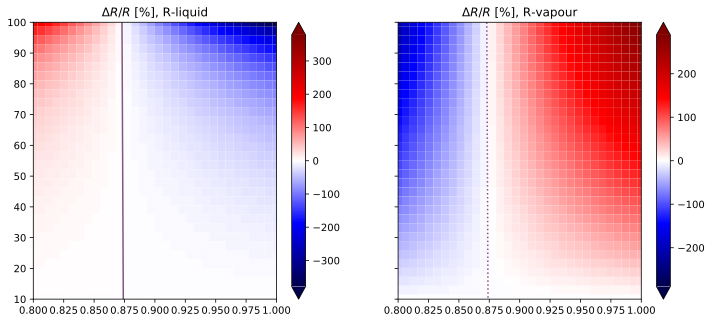

In [35]:
TEMPERATURES = np.linspace(C2K(-10) * si.K, C2K(30) * si.K, 9)
DELTAS_2H = (-300 * PER_MILLE, -200 * PER_MILLE, -100 * PER_MILLE)
fig, ax = pyplot.subplots(1, 2, figsize=(12, 5), sharex=True, sharey=True)
settings = GA_SET
fig2_x, fig2_y = plot(
    ax=ax,
    formulae=settings.formulae,
    isotope=settings.isotope,
    delta_v=settings.delta_v,
    temperature=settings.T,
    xlim=settings.x_range,
    ylim=(in_unit(settings.RH_range[0], PER_CENT), in_unit(settings.RH_range[-1], PER_CENT)),
    if_lines_on_one_plot=False,
)
phases = ["liquid", "vapour"]
for idx, data in enumerate([rel_diff_liq, rel_diff_vap]):
    pcm = ax[idx].pcolormesh(
        settings.norm_molecular_R_liq, in_unit(settings.RH[::-1], PER_CENT),
        data_percent := in_unit(data, PER_CENT),
        cmap="seismic",
        norm=mpl.colors.Normalize(vmax=(vmax := np.nanmax(np.abs(data_percent))), vmin=-vmax)
    )
    fig.colorbar(pcm, ax=ax[idx], extend="both")
    ax[idx].set_title(f"$\\Delta R/R$ [%], R-{phases[idx]}")

# TODO fix or remove annotations
annotate_kwargs = {'bbox': {'boxstyle': 'round', 'fc': '0.9'}, 'ha': 'center'}
pyplot.annotate(text="vapour ratio\n decreases", xy=(.84, .3), **annotate_kwargs)
pyplot.annotate(text="rain ratio\n decreases", xy=(.96, .7), **annotate_kwargs)
pyplot.annotate(text="both ratios\n increase", xy=(.94, .1), **annotate_kwargs)

show_plot('fig_2.pdf')

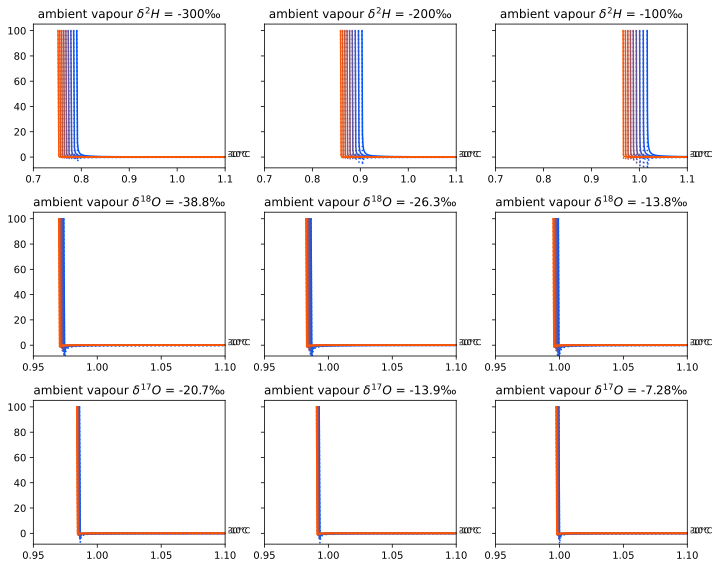

In [37]:
# TODO fix yrange on plots
formulae = Formulae(
    isotope_equilibrium_fractionation_factors='BarkanAndLuz2005+HoritaAndWesolowski1994',
    isotope_diffusivity_ratios='HellmannAndHarvey2020',
    isotope_meteoric_water_line='BarkanAndLuz2007+Dansgaard1964',
    isotope_ratio_evolution='GedzelmanAndArnold1994',
    isotope_ventilation_ratio='Neglect', # (this is not taken into account as it depends on droplet size which is not considered here)
)
deltas_18O = [formulae.isotope_meteoric_water_line.d18O_of_d2H(d2H) for d2H in DELTAS_2H]
deltas_17O = [formulae.isotope_meteoric_water_line.d17O_of_d18O(d18O) for d18O in deltas_18O]

fig, axs = pyplot.subplots(3, 3, figsize=(10,8), sharex=False, sharey=True, tight_layout=True) 

for ax_idx_iso, iso_label in enumerate(('2H', '18O', '17O')):
    for ax_idx_delta, delta_v in enumerate({
        '2H': DELTAS_2H,
        '18O': deltas_18O,
        '17O': deltas_17O,
    }[iso_label]):
        for i, temperature in enumerate(TEMPERATURES):
            plot(
                ax=[axs[ax_idx_iso][ax_idx_delta]],
                formulae=formulae,
                isotope=iso_label,
                delta_v=delta_v,
                temperature=temperature,
                xlim={
                    '2H': (.7, 1.1),
                    '18O': (.95, 1.1),
                    '17O': (.95, 1.1),
                }[iso_label],
                temperature_label=i in (0, len(TEMPERATURES)-1),
            )        
        if ax_idx_delta != 0:
            axs[ax_idx_iso][ax_idx_delta].set_ylabel('')
show_plot('plot_grid.pdf')